This notebook is for Kaggle's TalkingData AdTracking Fraud Detection Challenge. https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection      
This competition was aimed at classifying the behavior that produces lots of clicks, but never
end up downloading the app.       

Data provided by the organizer:  (Data sets can be downloaded at https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/data)    
    - test.csv, the testing data      
    - train.csv, the complete training data        
    - train_sample.csv, the subset training data which was randomly selected from train.csv.    
Data fieles: 
- `ip`: ip address of click.     
- `app`: app id for marketing.   
- `device`: device type id of user mobile phone.
- `os`: os version id of user mobile phone.
- `channel`: channel id of mobile ad publisher.
- `click_time`: timestamp of click (UTC).   
- `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download.   
- `is_attribted`: the target that is to be predicted, indicating the app was downloaded. 

Because the features, `ip`, `app`, `device`, `os`, and `channel`, are already encoded, there is not direct information telling us the insight amoung these features. We need to use EDA to dig patterns hidden behind them.          

##### Code Overview:   
- Load data   
- Exploratory data analysis (EDA):        
    - How balance the data is.    
    - Conversion rates based on different features.   
    - Time-related patterns.    
- Feature engineering:    
    - Add features about conversion rate.   
    - Add features about `channel`.    
- Modeling:    
    - Use Lightgbm to build the model.    
    - Use `AUC` as evaluation metric.    
- Model interpretation:
    - Feature importance.

In [1]:
import pandas as pd
import os
import subprocess
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

In [2]:
# The file sizes for the training data
print(str(os.path.getsize("data/train.csv")) + "MB")
print(str(os.path.getsize("data/test.csv")) + "MB")

7537649302MB
863271911MB


In [3]:
# The number of lines for the training data
! wc -l data/train.csv
! wc -l data/test.csv

 184903891 data/train.csv
 18790470 data/test.csv


Because the training data is very large (~7.5GB, ~185M lines), I used the last 20M lines as my training data, i.e. subset_train.csv    
The `subse_train.csv` is generated from the command line below:      
tail -n 20000000 train.csv > subset_train.csv}

In [135]:
%time train = pd.read_csv("data/subset_train.csv")

<string>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 15.3 s, sys: 3.3 s, total: 18.6 s
Wall time: 20.5 s


In [155]:
test = pd.read_csv("data/test.csv")

In [136]:
train[["ip", "app", "device", "os", "channel"]] = train[["ip", "app", "device", "os", "channel"]].astype("object")
train["click_time"] = pd.to_datetime(train["click_time"])
train["attributed_time"] = pd.to_datetime(train["attributed_time"])

In [156]:
test[["ip", "app", "device", "os", "channel"]] = test[["ip", "app", "device", "os", "channel"]].astype("object")
test["click_time"] = pd.to_datetime(test["click_time"])

In [8]:
train.dtypes

ip                         object
app                        object
device                     object
os                         object
channel                    object
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed               int64
dtype: object

In [9]:
print(train.shape)
print(test.shape)

(20000000, 8)
(18790469, 7)


## EDA

In [55]:
# ip, app, device, os, and channel are encoded. 
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,195051,3,1,13,317,2017-11-09 09:58:58,NaN,0
1,14348,12,1,18,265,2017-11-09 09:58:58,NaN,0
2,106460,2,1,18,219,2017-11-09 09:58:58,NaN,0
3,53617,3,1,19,379,2017-11-09 09:58:58,NaN,0
4,67249,14,1,22,489,2017-11-09 09:58:58,NaN,0


In [30]:
# Check the missing values in the training data set
train.isnull().sum()

ip                        0
app                       0
device                    0
os                        0
channel                   0
click_time                0
attributed_time    19952821
is_attributed             0
dtype: int64

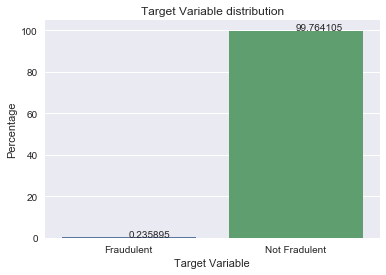

In [18]:
# Check if the target variable is unbalanced
# Based on the plot below, the data is very unbalanced
perc_notFradulent = (train.is_attributed.value_counts())[0] * 100 /train.shape[0]
perc_Fraudulent = (train.is_attributed.value_counts())[1] * 100 / train.shape[0]
ax = sns.barplot(["Fraudulent", "Not Fradulent"], 
                 [perc_Fraudulent, perc_notFradulent])
ax.set(xlabel="Target Variable", ylabel="Percentage", title="Target Variable distribution")
for p, num in zip(ax.patches, [perc_Fraudulent, perc_notFradulent]):
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.1, str(num))

In [79]:
# Number of unique categories in the categorical variables (ip, app, device, os, channel)
pd.DataFrame(data={"ip_nunique": train.ip.nunique(),
              "app_nunique": train.app.nunique(),
              "device_nunique": train.device.nunique(),
              "os_nunique": train.os.nunique(),
              "channel_nunique": train.channel.nunique()}, index=[0])

,app_nunique,channel_nunique,device_nunique,ip_nunique,os_nunique
0,417,182,1698,85029,370


#### Conversion rate

In [138]:
def conversion_rate(df, feat):
    counts = df.groupby([feat]).size()
    download_counts = df[df["is_attributed"]==1].groupby([feat]).size()
    conversion = download_counts / counts
    
    return conversion

In [139]:
ip_conversion = conversion_rate(train, "ip").fillna(0)

Text(0.5,1,"Moving average for the ip's conversion rate")

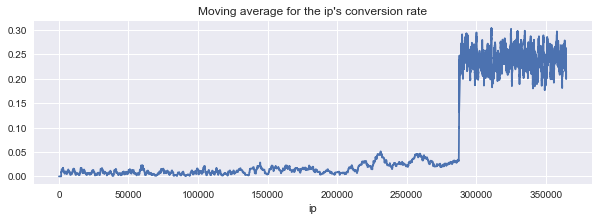

In [198]:
plt.figure(figsize=(10,3))
plt.plot(ip_conversion.rolling(window=300).mean().fillna(0))
plt.xlabel("ip")
plt.title("Moving average for the ip's conversion rate")

In [194]:
# The range of IPs in the test data
print(test.ip.min())
print(test.ip.max())

0
126413


In [140]:
app_conversion = conversion_rate(train, "app").fillna(0)

In [141]:
device_conversion = conversion_rate(train, "device").fillna(0)

In [142]:
os_conversion = conversion_rate(train, "os").fillna(0)

In [143]:
channel_conversion = conversion_rate(train, "channel").fillna(0)

#### Time features

In [ ]:
# Since the rows in the train_sample.csv were randomly selected from the training,
# the train_sample.csv has wider range of time span

In [245]:
random_train = pd.read_csv("data/train_sample.csv")
random_train["click_time"] = pd.to_datetime(random_train["click_time"])
random_train["attributed_time"] = pd.to_datetime(random_train["attributed_time"])

In [252]:
random_train["round_to_hour"] = random_train["click_time"].dt.round("H")

Text(0.5,1,'Hourly click counts')

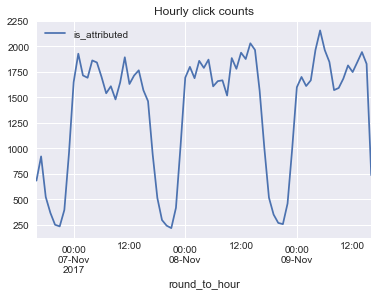

In [253]:
random_train[["round_to_hour", "is_attributed"]].groupby(["round_to_hour"]).count().plot()
plt.title("Hourly click counts")

Text(0.5,1,'Hourly conversion rate')

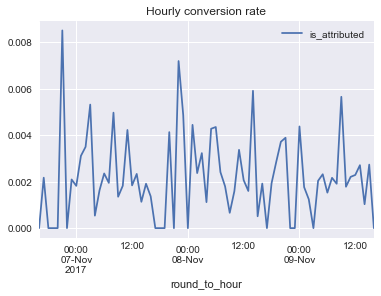

In [254]:
random_train[["round_to_hour", "is_attributed"]].groupby(["round_to_hour"]).mean().plot()
plt.title("Hourly conversion rate")

In [256]:
random_train["click_hour"] = random_train["click_time"].dt.hour

Text(0.5,1,'Hourly click counts grouped by hour')

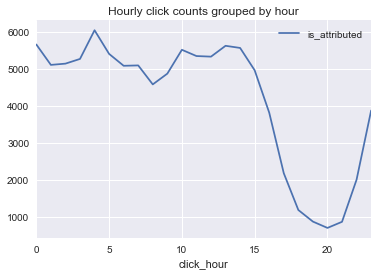

In [260]:
random_train[["click_hour", "is_attributed"]].groupby(["click_hour"]).count().plot()
plt.title("Hourly click counts grouped by hour")

Text(0.5,1,'Hourly conversion rate grouped by hour')

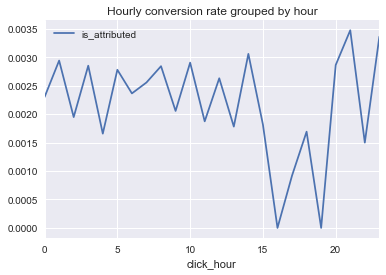

In [263]:
random_train[["click_hour", "is_attributed"]].groupby(["click_hour"]).mean().plot()
plt.title("Hourly conversion rate grouped by hour")

Text(0.5,1,'Hourly conversion rate grouped by hour with error bar')

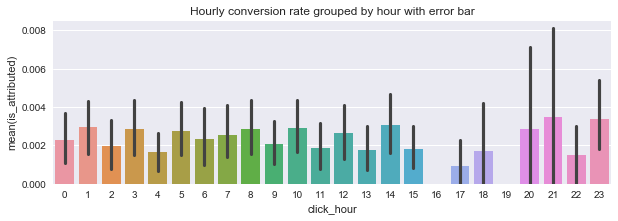

In [266]:
# The variance at hours with fewer data points is large.
plt.figure(figsize=(10, 3))
sns.barplot('click_hour', 'is_attributed', data=random_train)
plt.title("Hourly conversion rate grouped by hour with error bar")

##### Check how much time passed from clicking to downloading

In [268]:
# In train_sample.csv
(random_train["attributed_time"] - random_train["click_time"]).describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
dtype: object

In [269]:
# In the training data (the bottonm 20M lines in the train data set)
# The minimum time gap, 0s, is very suspicious. It doesn't look like a human behavior. 
(train["attributed_time"] - train["click_time"]).describe()

count                     47179
mean     0 days 00:23:35.267237
std      0 days 00:49:17.681782
min             0 days 00:00:00
25%             0 days 00:00:48
50%             0 days 00:02:24
75%             0 days 00:16:52
max             0 days 05:54:05
dtype: object

## Feature Engineering

In [173]:
def merge_feat(train, test, new_feat, common_feat, col_name):
    new_feat = new_feat.to_frame()
    new_feat.columns = [col_name]
    train = train.merge(new_feat, left_on=common_feat, right_index=True, how="left")
    test = test.merge(new_feat, left_on=common_feat, right_index=True, how="left").fillna(new_feat.mean())
    return train, test

In [174]:
train = merge_feat(train, test, ip_conversion, "ip", "ip_conversion")[0]
test = merge_feat(train, test, ip_conversion, "ip", "ip_conversion")[1]

In [176]:
train = merge_feat(train, test, app_conversion, "app", "app_conversion")[0]
test = merge_feat(train, test, app_conversion, "app", "app_conversion")[1]

In [177]:
train = merge_feat(train, test, device_conversion, "device", "device_conversion")[0]
test = merge_feat(train, test, device_conversion, "device", "device_conversion")[1]

In [178]:
train = merge_feat(train, test, os_conversion, "os", "os_conversion")[0]
test = merge_feat(train, test, os_conversion, "os", "os_conversion")[1]

In [179]:
train = merge_feat(train, test, channel_conversion, "channel", "channel_conversion")[0]
test = merge_feat(train, test, channel_conversion, "channel", "channel_conversion")[1]

In [180]:
train["click_hour"] = train["click_time"].dt.hour
test["click_hour"] = test["click_time"].dt.hour

In [181]:
# count channel grouping by ip and hour 
group_df = train[["ip", "click_hour", "channel"]].groupby(by=["ip", "click_hour"])["channel"].count().reset_index().rename(index=str, columns={'channel': 'channel_cnt_gp_ip_hour'})

In [182]:
train = train.merge(group_df, how="left", on=["ip", "click_hour"])

In [183]:
test = test.merge(group_df, how="left", on=["ip", "click_hour"]).fillna(group_df.channel_cnt_gp_ip_hour.mean())

In [184]:
# count channel grouping by ip and app 
group_df = train[["ip", "app", "channel"]].groupby(by=["ip", "app"])["channel"].count().reset_index().rename(index=str, columns={'channel': 'channel_cnt_gp_ip_app'})

In [185]:
train = train.merge(group_df, how="left", on=["ip", "app"])

In [186]:
test = test.merge(group_df, how="left", on=["ip", "app"]).fillna(group_df.channel_cnt_gp_ip_app.mean())

In [187]:
# count channel grouping by ip, app, and os
group_df = train[["ip", "app", "os", "channel"]].groupby(by=["ip", "app", "os"])["channel"].count().reset_index().rename(index=str, columns={'channel': 'channel_cnt_gp_ip_app_os'})
train = train.merge(group_df, how="left", on=["ip", "app", "os"])

In [188]:
test = test.merge(group_df, how="left", on=["ip", "app", "os"]).fillna(group_df.channel_cnt_gp_ip_app_os.mean())

In [189]:
train.to_csv("data/train_feat_eng.csv", index=False)
test.to_csv("data/test_feat_eng.csv", index=False)

### Prepare data for modeling

Since in the test data set, the maximum ip value is 126413, and also ip values less than around 300000 have very different conversion patterns thant the ip values beyond 300000, the validation data set should be chosen carefully.    
Because we want the validation data set to represent the test data set, I randomly selecte 20% of the training data as the validation data set from the rows with ip values less and equal than 126413.    

In [3]:
num_train = int(train.shape[0] * 0.8)
num_val = train.shape[0] - num_train

In [4]:
val_df = train[train["ip"] <= 126413].sample(num_val)

In [5]:
train_df = train[~train.index.isin(list(val_df.index))]

In [66]:
val_df_X = val_df.drop(["click_time", "attributed_time", "is_attributed"], axis=1)
train_df_X = train_df.drop(["click_time", "attributed_time", "is_attributed"], axis=1)
val_df_y = val_df.is_attributed.values
train_df_y = train_df.is_attributed.values

### LightGBM modeling

In [60]:
import lightgbm as lgb

In [67]:
# predictors = ["ip","device", "app", "os", "channel", "click_hour",
             'channel_cnt_gp_ip_hour', 'channel_cnt_gp_ip_app','channel_cnt_gp_ip_app_os']

In [73]:
xgtrain = lgb.Dataset(train_df_X.values, label=train_df_y)
xgval = lgb.Dataset(val_df_X.values, label=val_df_y)

From EDA, we know that the data is super unbalanced, I set the `scale_pos_weight` to 99 to solve the imbalance problem

In [74]:
params = {"learning_rate": 0.1,"boosting_type": "gbdt", "metric": "auc", 
          "objective": "binary", "max_depth": 4, "subsample": 0.8, 
          "scale_pos_weight": 99}
evals_results={}

In [76]:
model = lgb.train(params, xgtrain, valid_sets=[xgtrain, xgval], valid_names=["train", "val"],
                  evals_result=evals_results, num_boost_round=500, early_stopping_rounds=20)

[1]	train's auc: 0.980906	val's auc: 0.945378
Training until validation scores don't improve for 20 rounds.
[2]	train's auc: 0.981941	val's auc: 0.947428
[3]	train's auc: 0.982358	val's auc: 0.948172
[4]	train's auc: 0.982622	val's auc: 0.948621
[5]	train's auc: 0.983741	val's auc: 0.951874
[6]	train's auc: 0.984456	val's auc: 0.953564
[7]	train's auc: 0.984983	val's auc: 0.955134
[8]	train's auc: 0.985327	val's auc: 0.955385
[9]	train's auc: 0.985423	val's auc: 0.955494
[10]	train's auc: 0.985514	val's auc: 0.955486
[11]	train's auc: 0.985926	val's auc: 0.9571
[12]	train's auc: 0.98619	val's auc: 0.957777
[13]	train's auc: 0.986326	val's auc: 0.957936
[14]	train's auc: 0.986484	val's auc: 0.958615
[15]	train's auc: 0.98657	val's auc: 0.958819
[16]	train's auc: 0.986684	val's auc: 0.959232
[17]	train's auc: 0.986854	val's auc: 0.959915
[18]	train's auc: 0.986925	val's auc: 0.960322
[19]	train's auc: 0.986963	val's auc: 0.960425
[20]	train's auc: 0.987071	val's auc: 0.960941
[21]	train'

[174]	train's auc: 0.991602	val's auc: 0.972485
[175]	train's auc: 0.991608	val's auc: 0.972498
[176]	train's auc: 0.991608	val's auc: 0.972498
[177]	train's auc: 0.991612	val's auc: 0.972497
[178]	train's auc: 0.991622	val's auc: 0.972516
[179]	train's auc: 0.99163	val's auc: 0.972544
[180]	train's auc: 0.991652	val's auc: 0.972541
[181]	train's auc: 0.991664	val's auc: 0.972552
[182]	train's auc: 0.991675	val's auc: 0.972537
[183]	train's auc: 0.991682	val's auc: 0.972563
[184]	train's auc: 0.99169	val's auc: 0.97259
[185]	train's auc: 0.991704	val's auc: 0.972614
[186]	train's auc: 0.991707	val's auc: 0.97262
[187]	train's auc: 0.991722	val's auc: 0.972631
[188]	train's auc: 0.991723	val's auc: 0.972635
[189]	train's auc: 0.99174	val's auc: 0.972645
[190]	train's auc: 0.991747	val's auc: 0.972648
[191]	train's auc: 0.991758	val's auc: 0.972667
[192]	train's auc: 0.991776	val's auc: 0.972683
[193]	train's auc: 0.991792	val's auc: 0.972704
[194]	train's auc: 0.991798	val's auc: 0.9727

[346]	train's auc: 0.992751	val's auc: 0.973327
[347]	train's auc: 0.992751	val's auc: 0.973326
[348]	train's auc: 0.992752	val's auc: 0.973328
[349]	train's auc: 0.992754	val's auc: 0.973325
[350]	train's auc: 0.992754	val's auc: 0.973331
[351]	train's auc: 0.992759	val's auc: 0.97332
[352]	train's auc: 0.992769	val's auc: 0.973321
[353]	train's auc: 0.992773	val's auc: 0.973323
[354]	train's auc: 0.992774	val's auc: 0.973326
[355]	train's auc: 0.992776	val's auc: 0.973327
[356]	train's auc: 0.992777	val's auc: 0.973328
[357]	train's auc: 0.992784	val's auc: 0.973321
[358]	train's auc: 0.992788	val's auc: 0.973322
[359]	train's auc: 0.992793	val's auc: 0.973308
[360]	train's auc: 0.992803	val's auc: 0.973305
[361]	train's auc: 0.99281	val's auc: 0.973302
[362]	train's auc: 0.992812	val's auc: 0.973304
Early stopping, best iteration is:
[342]	train's auc: 0.992726	val's auc: 0.973332


In [92]:
n_iterations = model.best_iteration
best_train_auc = model.best_score["train"]["auc"]
best_val_auc = model.best_score["val"]["auc"]

In [96]:
print("The optimal number of iterations is", n_iterations, " with train auc %.4f" %best_train_auc,
     " and val auc %.4f" %best_val_auc)

The optimal number of iterations is 342  with train auc 0.9927  and val auc 0.9733


In [190]:
pred_test = model.predict(test.drop(["click_id","click_time"], axis=1), num_iteration=n_iterations)

In [198]:
test["is_attributed"] = pred_test
test[["click_id", "is_attributed"]].to_csv("submission.csv", index=False)

In [ ]:
a.to_csv("submission.csv", index=True)

In [203]:
pd.read_csv("submission.csv").head()

,is_attributed
0,0.000021
1,0.116874
2,0.000008
3,0.014103
4,0.029944


### Feature importance

In [112]:
cols = train_df_X.columns.values

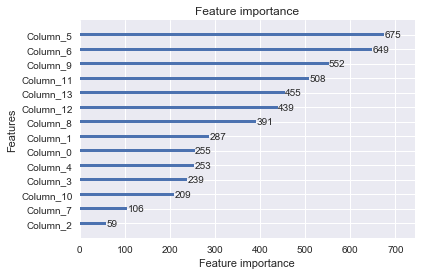

In [115]:
lgb.plot_importance(model)

In [120]:
feat_imp = pd.DataFrame()
feat_imp["features"] = [cols[5], cols[6], cols[9], cols[11], cols[13], cols[12],
           cols[8], cols[1], cols[0], cols[4], cols[3], cols[10], cols[7], cols[2]]
feat_imp["importance"] = sorted(model.feature_importance(), reverse=True)

From the table shown below, we can see that the top five important features are `ip_conversion`, `app_conversion`, `channel_conversion`, `channel_cnt_gp_ip_hour` (the channel counts after grouping by `ip` and `click_hour`), `channel_cnt_gp_ip_app` (the channel counts after grouping by `ip` and `app`).       
Overall, from the table, we can say that except for the conversion rates, `channel` also brings important insights. 

In [121]:
feat_imp

,features,importance
0,ip_conversion,675
1,app_conversion,649
2,channel_conversion,552
3,channel_cnt_gp_ip_hour,508
4,channel_cnt_gp_ip_app_os,455
5,channel_cnt_gp_ip_app,439
6,os_conversion,391
7,app,287
8,ip,255
9,channel,253
